# Kaggle Competiton | Telstra Network Disruptions

>In their first recruiting competition, Telstra is challenging Kagglers to predict the severity of service disruptions on their network. Using a dataset of features from their service logs, you're tasked with predicting if a disruption is a momentary glitch or a total interruption of connectivity.

>Telstra is on a journey to enhance the customer experience - ensuring everyone in the company is putting customers first. In terms of its expansive network, this means continuously advancing how it predicts the scope and timing of service disruptions. Telstra wants to see how you would help it drive customer advocacy by developing a more advanced predictive model for service disruptions and to help it better serve its customers.

>This challenge was crafted as a simulation of the type of problem you might tackle as a member of the team at Telstra.

Go to the official page of the [Kaggle Competition.](https://www.kaggle.com/c/telstra-recruiting-network)

### Goal for this Notebook:
In the case of this competition, we do not have previous information about the data and the different features. Therefore, in this notebook we will:
* Explore the format of data given and the format expected for the submission
* Explore the different data types in the features

### Required Libraries
* Pandas
* Numpy
* Matplotlib
* Seaborn
* Sklearn
* Scipy

In [1]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import seaborn as sns
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import grid_search
from scipy import stats

%matplotlib inline

/usr/local/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


### 1. Handle Data
###### Load Data 

In [2]:
event = pd.read_csv("../../../github_data/telstradisr_data/event_type.csv")
log = pd.read_csv("../../../github_data/telstradisr_data/log_feature.csv")
sample = pd.read_csv("../../../github_data/telstradisr_data/sample_submission.csv")
severity = pd.read_csv("../../../github_data/telstradisr_data/severity_type.csv")
resource = pd.read_csv("../../../github_data/telstradisr_data/resource_type.csv")
train = pd.read_csv("../../../github_data/telstradisr_data/train.csv")
test = pd.read_csv("../../../github_data/telstradisr_data/test.csv")

In [3]:
train.head()

,id,location,fault_severity
0,14121,location 118,1
1,9320,location 91,0
2,14394,location 152,1
3,8218,location 931,1
4,14804,location 120,0


In [4]:
event.head()

,id,event_type
0,6597,event_type 11
1,8011,event_type 15
2,2597,event_type 15
3,5022,event_type 15
4,5022,event_type 11


In [5]:
log.head()

,id,log_feature,volume
0,6597,feature 68,6
1,8011,feature 68,7
2,2597,feature 68,1
3,5022,feature 172,2
4,5022,feature 56,1


In [6]:
severity.head()

,id,severity_type
0,6597,severity_type 2
1,8011,severity_type 2
2,2597,severity_type 2
3,5022,severity_type 1
4,6852,severity_type 1


In [7]:
resource.head()

,id,resource_type
0,6597,resource_type 8
1,8011,resource_type 8
2,2597,resource_type 8
3,5022,resource_type 8
4,6852,resource_type 8


In [8]:
test.head()

,id,location
0,11066,location 481
1,18000,location 962
2,16964,location 491
3,4795,location 532
4,3392,location 600


In [9]:
sample.head()

,id,predict_0,predict_1,predict_2
0,11066,0,1,0
1,18000,0,1,0
2,16964,0,1,0
3,4795,0,1,0
4,3392,0,1,0


After having a look into the tables we can extract several conclusions. 
- The first one is that the train and test tables are not complete, the other tables need to be merged with them. 
- The second one is that in several cases the columns are a combination of a string and an integer and we will need to clean them to have just the integer.
- The third is that we may generate as an output a data frame with the prediction for three classes where each of them should be represented as a column with boolean values 0 and 1.

###### Clean Data 

In [10]:
event['event_type'] = event['event_type'].str.split(' ').str[1]
log['log_feature'] = log['log_feature'].str.split(' ').str[1]
severity['severity_type'] = severity['severity_type'].str.split(' ').str[1]
resource['resource_type'] = resource['resource_type'].str.split(' ').str[1]
test['location'] = test['location'].str.split(' ').str[1]
train['location'] = train['location'].str.split(' ').str[1]

###### Explore Data

We would process the data differently depending on the data type. Thus, the next step is to check, for each feature in the different tables, the data type. For this aim we will plot it.

We should mention that we do not have any information about the different features but that the "severity_type" is a categorical feature.

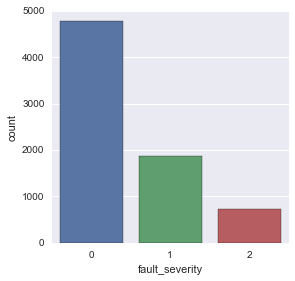

In [15]:
sns.factorplot('fault_severity',data=train,kind='count',size=4)

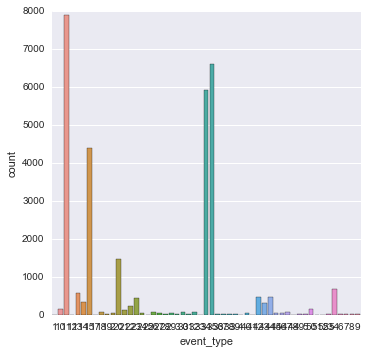

In [14]:
sns.factorplot('event_type',data=event,kind='count',size=5)

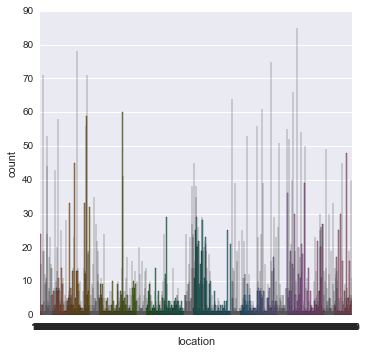

In [26]:
sns.factorplot('location',data=train,kind='count',size=5)

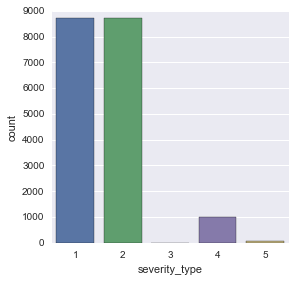

In [22]:
sns.factorplot('severity_type',data=severity,kind='count',size=4)

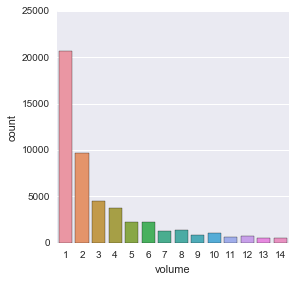

In [23]:
sns.factorplot('volume',data=log[log['volume'] < 15],kind='count',size=4)

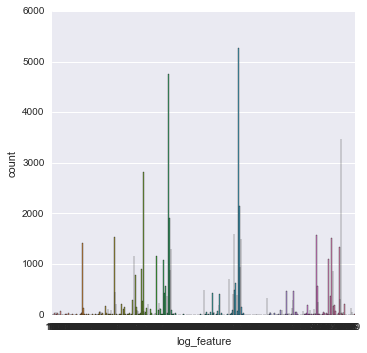

In [24]:
sns.factorplot('log_feature',data=log,kind='count',size=5)

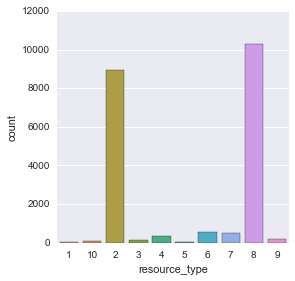

In [25]:
sns.factorplot('resource_type',data=resource,kind='count',size=4)

The features that includes "type" in the name look like categorical. "Volume" could be continous. However, we do not have enough information to decide. We will consider and process all the features as categorical integers.

Furthermore, we would like if there is any correlation between the location and the fault_severity. It could be that a given type of fault is produced always in specific locations.

In [34]:
train0 = train.groupby('fault_severity').get_group(0)
train1 = train.groupby('fault_severity').get_group(1)
train2 = train.groupby('fault_severity').get_group(2)

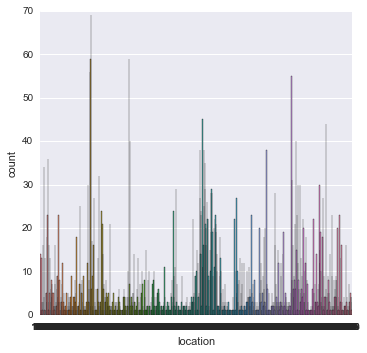

In [35]:
sns.factorplot('location',data=train0,kind='count',size=5)

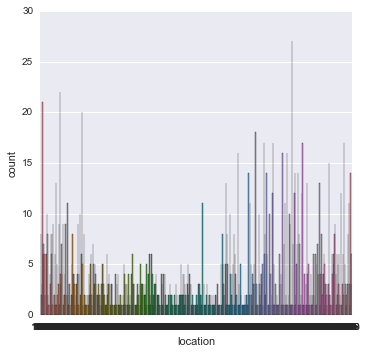

In [36]:
sns.factorplot('location',data=train1,kind='count',size=5)

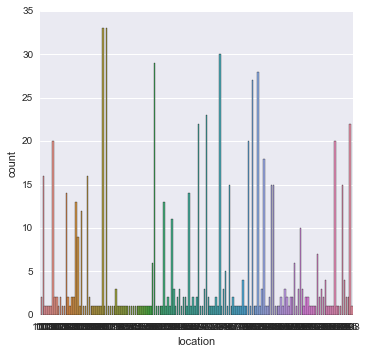

In [37]:
sns.factorplot('location',data=train2,kind='count',size=5)

The plots show that "fault_severity 0" does not have an specific location. We may also mention that most of the events are classified as "fault_severity 0" therefore it may be a pretty common fault.

On the other hand, in the case of "fault_severity 2" one can observe a more specific location for these events.

In the next notebook (clean_group_eval.ipynb) we will explain how to process this categorical data.